In [1]:
import yaml
import cv2
from predictor import Predictor
from common.eval_util import compute_auc
from tqdm import tqdm
import numpy as np
import os



In [2]:
#config is in the same folder as this file
config_path = './config/test.yaml'
if os.path.exists(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
else:
    raise FileNotFoundError("Config File doesn't Exist")

predict_config = config['PREDICT']
data_path = './'  # Change the data_path according to your own setup
testset = 'FIRE'
use_matching_trick = config['PREDICT']['use_matching_trick']
gt_dir = os.path.join(data_path, testset, 'Ground Truth')
im_dir = os.path.join(data_path, testset, 'Images')

match_pairs = [x for x in os.listdir(gt_dir) if x.endswith('.txt')
               and not x.endswith('P37_1_2.txt')]
# metrics
big_num = 1e6
good_nums_rate = []
image_num = 0

failed = 0
inaccurate = 0
mae = 0
mee = 0

# category: S, P, A, corresponding to Easy, Hard, Mod in paper
auc_record = dict([(category, []) for category in ['S', 'P', 'A']])


In [4]:
Pred = Predictor(config)
query_path = './samples/query.jpg'
refer_path = './samples/refer.jpg'


/Users/deepamdibyajyot/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


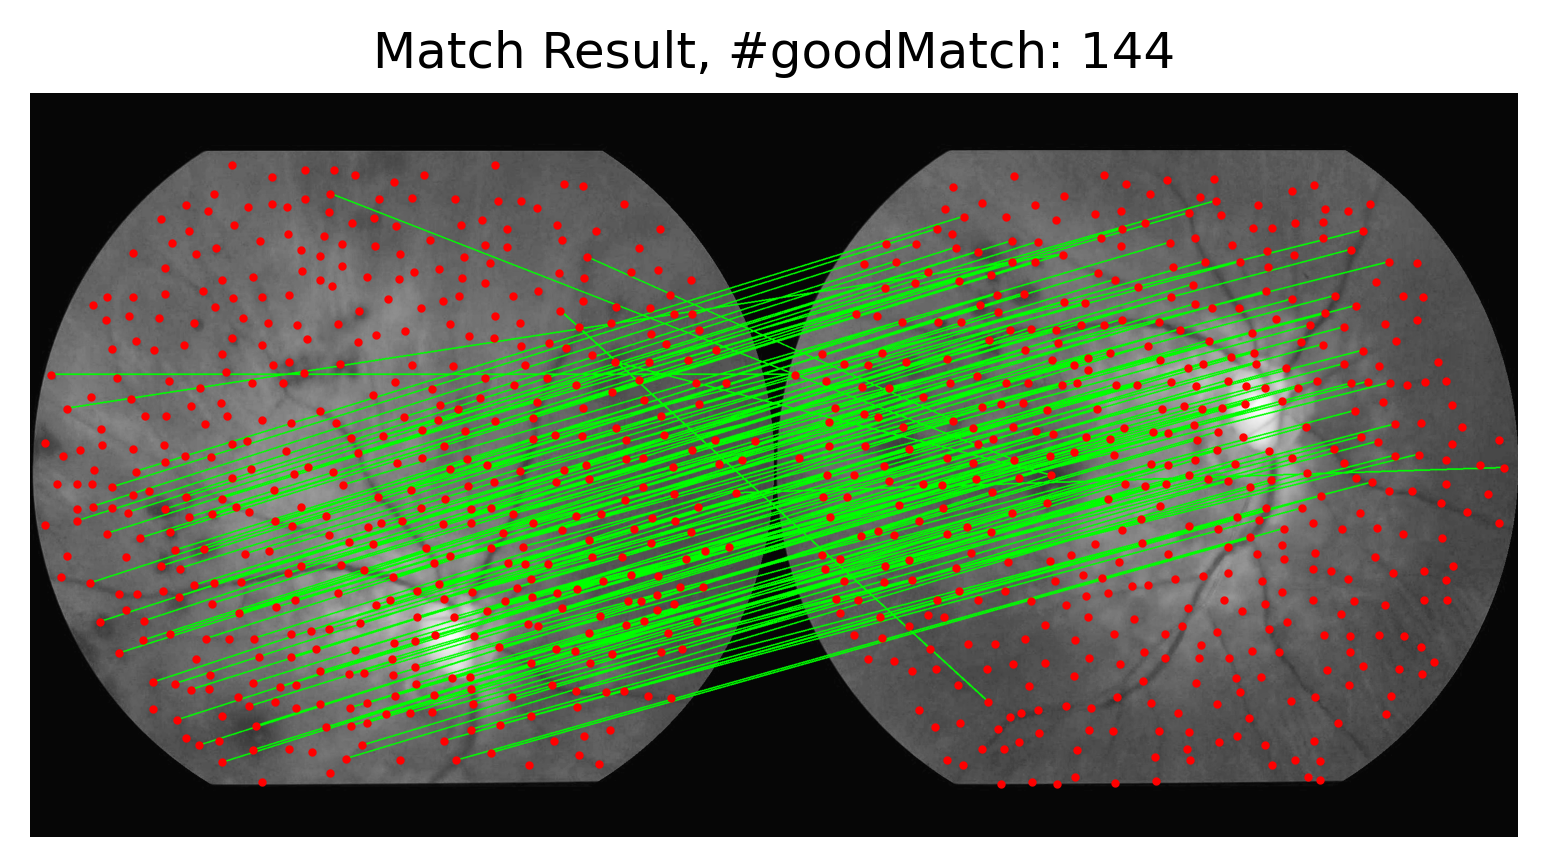

In [5]:
if query_path is not None:
    goodMatch, cv_kpts_query, cv_kpts_refer, \
        raw_query_image, raw_refer_image = Pred.match(
            query_path, refer_path, show=True)
else:
    print('query path is None, doesn\'t show matching')


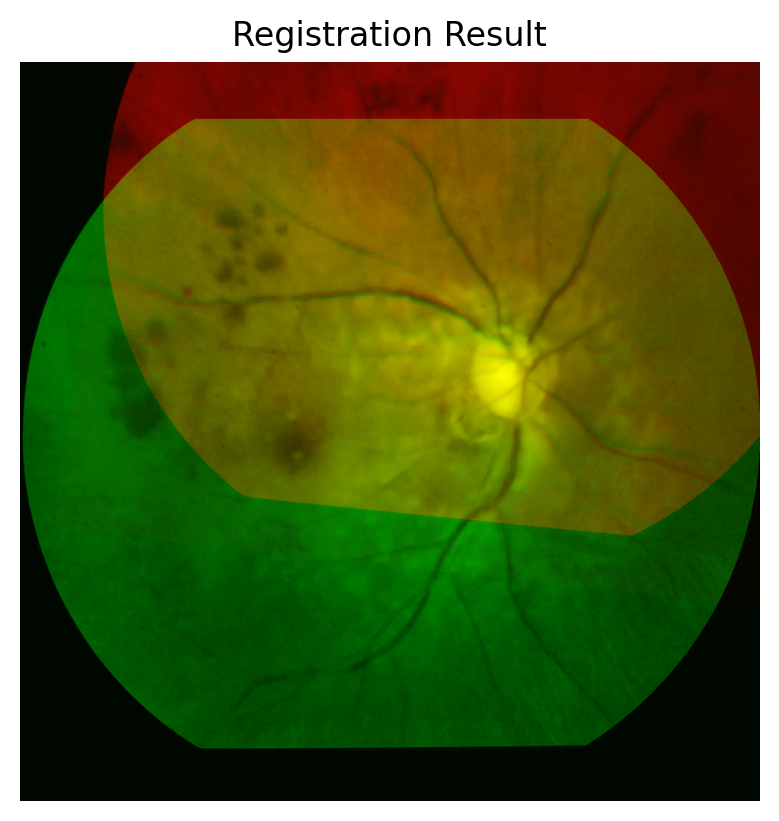

Homography Matrix is :
[[ 9.92614913e-01 -1.36020176e-01  2.50207456e+02]
 [ 1.12845302e-01  9.72572772e-01 -4.90720137e+02]
 [ 5.56857194e-06 -1.72266995e-05  1.00000000e+00]]
The rate of inliers is 95.139%


In [6]:
if query_path is not None:
    H_m, inliers_num_rate, raw_query_image, raw_refer_image = Pred.compute_homography(
        query_path, refer_path)
    merged = Pred.align_image_pair(query_path, refer_path, show=True)

    print("Homography Matrix is :")
    print(H_m)
    print("The rate of inliers is {:.3f}%".format(inliers_num_rate*100))
else:
    print('query path is None, doesn\'t show registration')


In [7]:
for pair_file in tqdm(match_pairs):
    gt_file = os.path.join(gt_dir, pair_file)
    file_name = pair_file.replace('.txt', '')

    category = file_name.split('_')[2][0]

    refer = file_name.split('_')[2] + '_' + file_name.split('_')[3]
    query = file_name.split('_')[2] + '_' + file_name.split('_')[4]

    query_im_path = os.path.join(im_dir, query + '.jpg')
    refer_im_path = os.path.join(im_dir, refer + '.jpg')
    H_m1, inliers_num_rate, query_image, _ = Pred.compute_homography(
        query_im_path, refer_im_path)
    H_m2 = None

    # Using matching trick will decrease inference speed but gain higher performance
    if use_matching_trick:
        if H_m1 is not None:
            h, w = Pred.image_height, Pred.image_width
            query_align_first = cv2.warpPerspective(query_image, H_m1, (w, h), borderMode=cv2.BORDER_CONSTANT,
                                                    borderValue=(0))
            query_align_first = query_align_first.astype(float)
            query_align_first /= 255.
            H_m2, inliers_num_rate, _, _ = Pred.compute_homography(
                query_align_first, refer_im_path, query_is_image=True)

    good_nums_rate.append(inliers_num_rate)
    image_num += 1

    if inliers_num_rate < 1e-6:
        failed += 1
        avg_dist = big_num
    else:
        points_gd = np.loadtxt(gt_file)
        raw = np.zeros([len(points_gd), 2])
        dst = np.zeros([len(points_gd), 2])
        raw[:, 0] = points_gd[:, 2]
        raw[:, 1] = points_gd[:, 3]
        dst[:, 0] = points_gd[:, 0]
        dst[:, 1] = points_gd[:, 1]
        dst_pred = cv2.perspectiveTransform(raw.reshape(-1, 1, 2), H_m1)
        if H_m2 is not None:
            dst_pred = cv2.perspectiveTransform(
                dst_pred.reshape(-1, 1, 2), H_m2)

        dst_pred = dst_pred.squeeze()

        dis = (dst - dst_pred) ** 2
        dis = np.sqrt(dis[:, 0] + dis[:, 1])
        avg_dist = dis.mean()

        mae = dis.max()
        mee = np.median(dis)
        if mae > 50 or mee > 20:
            inaccurate += 1

    auc_record[category].append(avg_dist)


100%|██████████| 133/133 [46:37<00:00, 21.03s/it]


In [8]:

print('-'*40)
print(f"Failed:{'%.2f' % (100*failed/image_num)}%, Inaccurate:{'%.2f' % (100*inaccurate/image_num)}%, "
      f"Acceptable:{'%.2f' % (100*(image_num-inaccurate-failed)/image_num)}%")

print('-'*40)

auc = compute_auc(auc_record['S'], auc_record['P'], auc_record['A'])
print('S: %.3f, P: %.3f, A: %.3f, mAUC: %.3f' %
      (auc['s'], auc['p'], auc['a'], auc['mAUC']))


----------------------------------------
Failed:0.00%, Inaccurate:0.75%, Acceptable:99.25%
----------------------------------------
S: 0.948, P: 0.547, A: 0.783, mAUC: 0.759
